**Stage**: Model Performance Analysis

---

## Objectives
- Evaluate the performance of linear regression models (with and without outliers) using metrics such as RMSE, MAE, and R².
- Visualize predictions and residuals to assess model accuracy.
- Analyze the impact of outliers (e.g., June 5, 2025) on model performance.

In [1]:
# Parameters for automation
stock_symbol = None  # e.g., 'TSLA'
fetch_id = None  # e.g., 'fetch_20250617_093553'
config_path = "config/config.json"
auto_generate_summary = False

# Data Source and Preparation
The analysis uses processed stock data from `data/processed/processed_{stock_symbol.lower()}_data.csv`, which includes 250 days of historical data with engineered features such as `prev_close`, `volume`, `ma5`, and `next_close`. This data was prepared using `process_data.py`.

In [2]:
import os
import json
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from spp.data_utils import load_config, load_data, extract_timestamp
from spp.logging_utils import setup_logging
from spp.plot_utils import plot_predictions, plot_residuals

# Define project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("__file__")), ".."))

# Initialize logger
logger = setup_logging(logger_name="model_analysis", log_dir="logs")

# Define functions with type hints and docstrings
def load_models(
    stock_symbol: str, 
    timestamp: str, 
    models_dir: str, 
    project_root: str
) -> Tuple[Any, Any]:
    """Load pre-trained models for stock price prediction with and without outliers.

    Args:
        stock_symbol (str): The stock symbol (e.g., 'TSLA').
        timestamp (str): The timestamp associated with the model training.
        models_dir (str): The directory where the model files are stored.
        project_root (str): The root directory of the project.

    Returns:
        Tuple[Any, Any]: A tuple containing the model trained with outliers and the model trained without outliers.
    """
    model_with_path = os.path.join(project_root, models_dir, f"model_{stock_symbol.lower()}_{timestamp}_with_outliers.pkl")
    model_without_path = os.path.join(project_root, models_dir, f"model_{stock_symbol.lower()}_{timestamp}_without_outliers.pkl")
    
    logger.info(f"Loading model with outliers from: {model_with_path}")
    model_with_outliers = joblib.load(model_with_path)
    logger.info(f"Loading model without outliers from: {model_without_path}")
    model_without_outliers = joblib.load(model_without_path)
    return model_with_outliers, model_without_outliers

def prepare_data(
    df: pd.DataFrame, 
    include_outliers: bool = True
) -> Tuple[pd.DataFrame, pd.Series]:
    """Prepare the feature and target data from the given DataFrame, optionally excluding outliers.

    Args:
        df (pd.DataFrame): The input DataFrame containing stock data.
        include_outliers (bool, optional): Whether to include outliers in the data. Defaults to True.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: A tuple containing the feature DataFrame (X) and the target Series (Y).
    """
    if not include_outliers:
        df = df[df['is_outlier'] == False]
    X = df[['prev_close', 'volume', 'ma5']]
    Y = df['next_close']
    return X, Y

def evaluate_model(
    Y_true: pd.Series, 
    Y_pred: pd.Series
) -> Dict[str, float]:
    """Evaluate the performance of a model using RMSE, MAE, and R² metrics.

    Args:
        Y_true (pd.Series): The true target values.
        Y_pred (pd.Series): The predicted target values.

    Returns:
        Dict[str, float]: A dictionary containing the RMSE, MAE, and R² scores.
    """
    rmse = root_mean_squared_error(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    r2 = r2_score(Y_true, Y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

def generate_summary(
    metrics_with: Dict[str, float], 
    metrics_without: Dict[str, float], 
    outlier_impact: str
) -> str:
    """Generate a formatted summary string of model performance metrics and outlier impact.

    Args:
        metrics_with (Dict[str, float]): Metrics for the model trained with outliers.
        metrics_without (Dict[str, float]): Metrics for the model trained without outliers.
        outlier_impact (str): A string describing the impact of outliers.

    Returns:
        str: A formatted string summarizing the model performances and outlier impact.
    """
    summary = f"""
    ## Model Performance Summary
    - **Model with Outliers**:
      - RMSE: {metrics_with['RMSE']:.2f}
      - MAE: {metrics_with['MAE']:.2f}
      - R²: {metrics_with['R2']:.2f}
    - **Model without Outliers**:
      - RMSE: {metrics_without['RMSE']:.2f}
      - MAE: {metrics_without['MAE']:.2f}
      - R²: {metrics_without['R2']:.2f}
    - **Outlier Impact (June 5, 2025)**:
      - {outlier_impact}
    """
    return summary

Logger 'model_analysis' has been set up with log level INFO


In [3]:
def main(
    stock_symbol=None, 
    fetch_id=None, 
    config_path=os.path.join(PROJECT_ROOT, "config", "config.json")
) -> None:
    """Analyze stock price prediction models with and without outliers.

    This function serves as the primary workflow for analyzing stock price prediction models.

    Args:
        stock_symbol (str, optional): The stock symbol to analyze (e.g., 'TSLA'). If not provided, defaults to the value in the config under 'current_fetch.stock_symbol'.
        fetch_id (str, optional): The identifier for the data fetch (e.g., 'fetch_20250617_093553'). If not provided, defaults to the value in the config under 'current_fetch.fetch_id'.
        config_path (str, optional): Path to the configuration file. Defaults to 'config/config.json' relative to the project root (constructed via `os.path.join(PROJECT_ROOT, "config", "config.json")`).

    Returns:
        None: This function does not return a value but performs actions such as logging, plotting, and printing.

    Logs:
        - Informational messages about the stock symbol, fetch ID, and timestamp.
        - Errors if timestamp extraction fails or model IDs are missing.
        - Errors if model loading fails.

    Raises:
        FileNotFoundError: If the model files cannot be found during the `load_models` call.
        Exception: Other unhandled exceptions from called functions (e.g., `load_data`, `prepare_data`) may propagate.
    """
    config = load_config(config_path, logger=logger)
    stock_symbol = stock_symbol or config.get("current_fetch", {}).get("stock_symbol", "TSLA")
    fetch_id = fetch_id or config.get("current_fetch", {}).get("fetch_id")
    model_id_with_outliers = config.get("current_models", {}).get("with_outliers")
    
    if model_id_with_outliers:
        try:
            timestamp = extract_timestamp(model_id_with_outliers)
        except ValueError as e:
            timestamp = "unknown"
            logger.error(f"Failed to extract timestamp from model ID: {e}")
    else:
        timestamp = "unknown"
        logger.error("No model ID found for 'with_outliers' in config")
    logger.info(f"Analyzing stock: {stock_symbol}, Fetch ID: {fetch_id}, Timestamp: {timestamp}")
    
    # Data preparation
    df = load_data(config, stock_symbol, fetch_id, data_type="processed", logger=logger)
    X_with, Y_with = prepare_data(df, include_outliers=True)
    X_without, Y_without = prepare_data(df, include_outliers=False)
    X_train_with, X_test_with, Y_train_with, Y_test_with = train_test_split(X_with, Y_with, test_size=0.2, shuffle=False)
    X_train_without, X_test_without, Y_train_without, Y_test_without = train_test_split(X_without, Y_without, test_size=0.2, shuffle=False)

    # Load models and generate predictions
    try:
        model_with, model_without = load_models(stock_symbol, timestamp, config["models_dir"], PROJECT_ROOT)
    except FileNotFoundError as e:
        logger.error(f"Failed to load models: {e}")
        raise
    Y_pred_with = model_with.predict(X_test_with)
    Y_pred_without = model_without.predict(X_test_without)

    # Evaluate models
    metrics_with = evaluate_model(Y_test_with, Y_pred_with)
    metrics_without = evaluate_model(Y_test_without, Y_pred_without)

    # Visualize
    plot_predictions(Y_test_with, pd.Series(Y_pred_with, index=Y_test_with.index), stock_symbol, timestamp, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
    plot_predictions(Y_test_without, pd.Series(Y_pred_without, index=Y_test_without.index), f"{stock_symbol}_no_outliers", timestamp, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
    plot_residuals(Y_test_with, Y_pred_with, "With Outliers", save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
    plot_residuals(Y_test_without, Y_pred_without, "Without Outliers", save=True, directory=os.path.join(PROJECT_ROOT, "plots"))

    # Outlier analysis
    outlier_date = '2025-06-05'
    if outlier_date in df.index:
        X_outlier = df.loc[[outlier_date], ['prev_close', 'volume', 'ma5']]
        Y_outlier_actual = df.loc[outlier_date, 'next_close']
        Y_outlier_pred_with = model_with.predict(X_outlier)[0]
        Y_outlier_pred_without = model_without.predict(X_outlier)[0]
        error_with = abs(Y_outlier_actual - Y_outlier_pred_with)
        error_without = abs(Y_outlier_actual - Y_outlier_pred_without)
        outlier_impact = f"Error with outliers: {error_with:.2f}, Error without outliers: {error_without:.2f}"
    else:
        outlier_impact = "Outlier date not found in data."

    # Generate summary
    if auto_generate_summary:
        summary = generate_summary(metrics_with, metrics_without, outlier_impact)
        print(summary)
    else:
        print("## Summary\n[Manual summary to be added here]")

# Comment out automatic execution in notebook
# if __name__ == "__main__":
#     main()

In [4]:
# Load config
config = load_config(config_path, logger=logger)
stock_symbol = stock_symbol or config.get("current_fetch", {}).get("stock_symbol", "TSLA")
fetch_id = fetch_id or config.get("current_fetch", {}).get("fetch_id")

# Extract timestamp from the model ID in config.json
model_id_with_outliers = config.get("current_models", {}).get("with_outliers")
logger.info(f"Retrieved model ID: {model_id_with_outliers}")  # Add this line to log the value
if model_id_with_outliers:
    try:
        timestamp = extract_timestamp(model_id_with_outliers)
    except ValueError as e:
        timestamp = "unknown"
        logger.error(f"Failed to extract timestamp from model ID: {e}")
else:
    timestamp = "unknown"
    logger.error("No model ID found for 'with_outliers' in config")
logger.info(f"Analyzing stock: {stock_symbol}, Fetch ID: {fetch_id}, Timestamp: {timestamp}")

Successfully loaded config file from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/config/config.json
Config keys: current_fetch, current_models, fetch_id, project_root, utils_dir, log_dir, plots_dir, models_dir, raw_data_dir, processed_data_dir, gaps_dir, outliers_dir, docs_data_eval_dir, docs_model_eval_dir
Retrieved model ID: model_tsla_20250730_102338_with_outliers
Analyzing stock: TSLA, Fetch ID: fetch_20250617_093553, Timestamp: 20250730_102338


In [5]:
# Load and prepare data
df = load_data(config, stock_symbol, fetch_id, data_type="processed", logger=logger)

# Prepare data with outliers
X_with, Y_with = prepare_data(df, include_outliers=True)
X_train_with, X_test_with, Y_train_with, Y_test_with = train_test_split(X_with, Y_with, test_size=0.2, shuffle=False)

# Prepare data without outliers
X_without, Y_without = prepare_data(df, include_outliers=False)
X_train_without, X_test_without, Y_train_without, Y_test_without = train_test_split(X_without, Y_without, test_size=0.2, shuffle=False)

Loaded processed data from /home/dielozmor/dev/projects/portfolio/stock-price-prediction/data/processed/processed_tsla_fetch_20250617_093553.csv with 250 rows


In [6]:
# Load models and generate predictions
models_dir = config["models_dir"]
project_root = PROJECT_ROOT
try:
    model_with, model_without = load_models(stock_symbol, timestamp, models_dir, project_root)
except FileNotFoundError as e:
    logger.error(f"Failed to load models: {e}")
    raise

# Generate predictions
Y_pred_with = model_with.predict(X_test_with)
Y_pred_without = model_without.predict(X_test_without)

Loading model with outliers from: /home/dielozmor/dev/projects/portfolio/stock-price-prediction/models/model_tsla_20250730_102338_with_outliers.pkl
Loading model without outliers from: /home/dielozmor/dev/projects/portfolio/stock-price-prediction/models/model_tsla_20250730_102338_without_outliers.pkl


# Model Evaluation

In [7]:
# Evaluate model with outliers
metrics_with = evaluate_model(Y_test_with, Y_pred_with)
logger.info(f"Model with outliers:\n"
            f"  RMSE: {metrics_with['RMSE']:.2f}\n"
            f"  MAE: {metrics_with['MAE']:.2f}\n"
            f"  R2: {metrics_with['R2']:.2f}")

# Evaluate model without outliers
metrics_without = evaluate_model(Y_test_without, Y_pred_without)
logger.info(f"Model without outliers:\n"
            f"  RMSE: {metrics_without['RMSE']:.2f}\n"
            f"  MAE: {metrics_without['MAE']:.2f}\n"
            f"  R2: {metrics_without['R2']:.2f}")

Model with outliers:
  RMSE: 19.54
  MAE: 14.47
  R2: 0.77
Model without outliers:
  RMSE: 19.16
  MAE: 14.30
  R2: 0.78


# Visualization

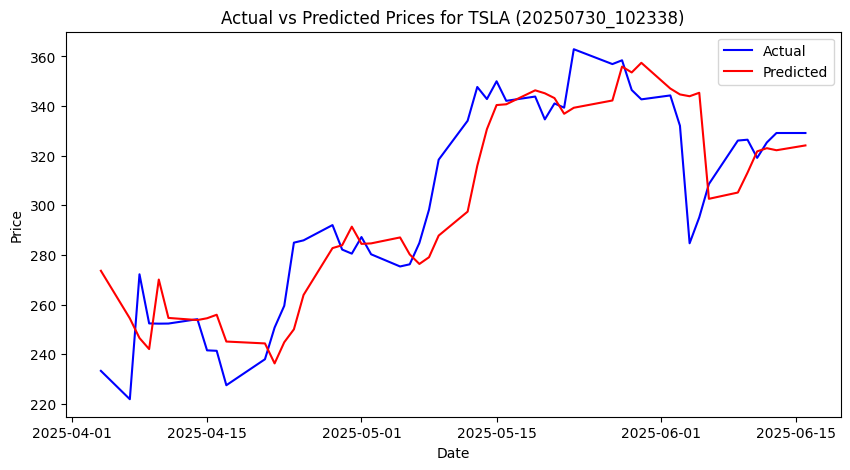

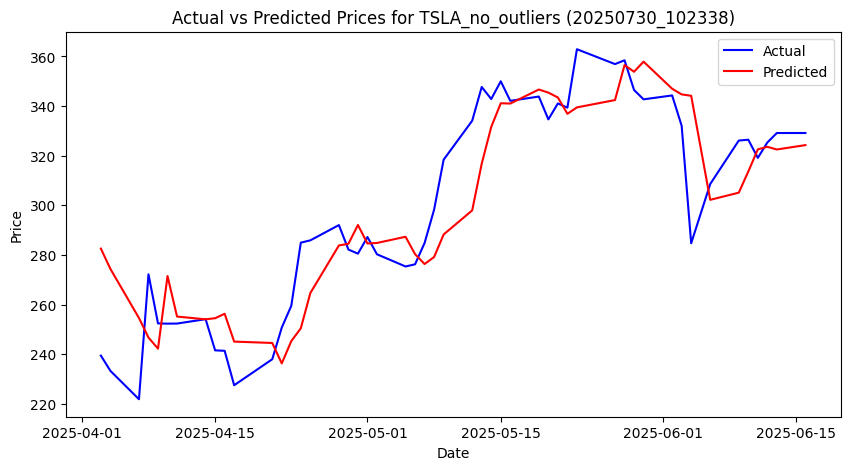

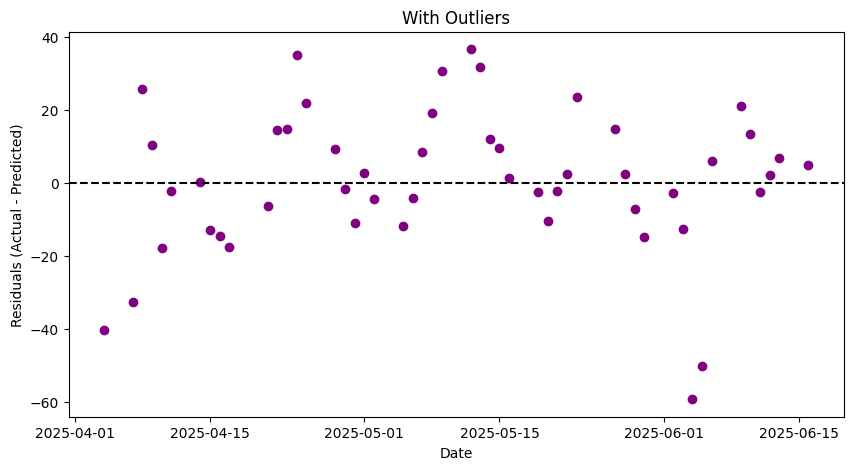

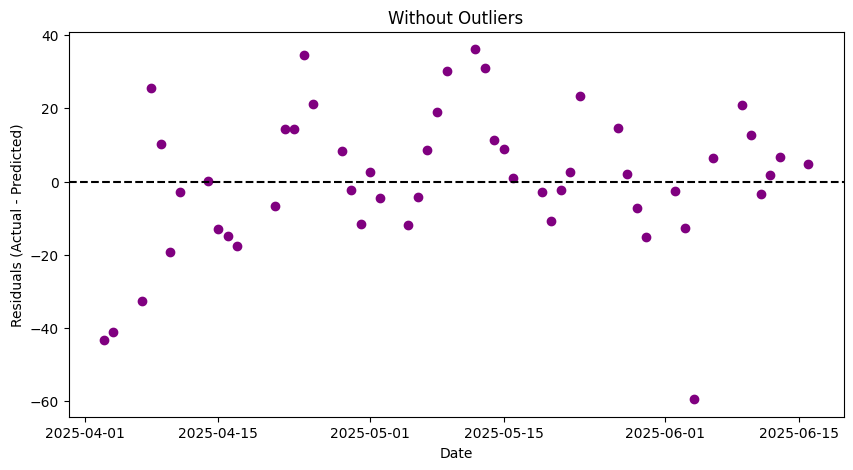

In [8]:
# Plot predictions
plot_predictions(Y_test_with, pd.Series(Y_pred_with, index=Y_test_with.index), stock_symbol, timestamp, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
plot_predictions(Y_test_without, pd.Series(Y_pred_without, index=Y_test_without.index), f"{stock_symbol}_no_outliers", timestamp, save=True, directory=os.path.join(PROJECT_ROOT, "plots"))

# Plot residuals
plot_residuals(Y_test_with, Y_pred_with, "With Outliers", save=True, directory=os.path.join(PROJECT_ROOT, "plots"))
plot_residuals(Y_test_without, Y_pred_without, "Without Outliers", save=True, directory=os.path.join(PROJECT_ROOT, "plots"))

In [9]:
outlier_date = '2025-06-05'
if outlier_date in df.index:
    X_outlier = df.loc[[outlier_date], ['prev_close', 'volume', 'ma5']]
    Y_outlier_actual = df.loc[outlier_date, 'next_close']
    Y_outlier_pred_with = model_with.predict(X_outlier)[0]
    Y_outlier_pred_without = model_without.predict(X_outlier)[0]
    error_with = abs(Y_outlier_actual - Y_outlier_pred_with)
    error_without = abs(Y_outlier_actual - Y_outlier_pred_without)
    logger.info(f"Outlier Analysis ({outlier_date}):")
    logger.info(f"  Actual: {Y_outlier_actual:.2f}")
    logger.info(f"  Predicted (with outliers): {Y_outlier_pred_with:.2f} (Error: {error_with:.2f})")
    logger.info(f"  Predicted (without outliers): {Y_outlier_pred_without:.2f} (Error: {error_without:.2f})")
    outlier_impact = f"Error with outliers: {error_with:.2f}, Error without outliers: {error_without:.2f}"
else:
    outlier_impact = "Outlier date not found in data."

Outlier Analysis (2025-06-05):
  Actual: 295.14
  Predicted (with outliers): 345.34 (Error: 50.20)
  Predicted (without outliers): 346.58 (Error: 51.44)


In [10]:
if auto_generate_summary:
    summary = generate_summary(metrics_with, metrics_without, outlier_impact)
    print(summary)

# Summary of Findings

## Model Performance
- **Variance Explained**: The linear regression models explain `77–78%` of the variance in TSLA’s next-day closing price (R² = 0.77 with outliers, 0.78 without), demonstrating that features such as previous closing price (`prev_close`), trading volume (`volume`), and 5-day moving average (`ma5`) are effective predictors.
- **Prediction Accuracy**:
  - **Mean Absolute Error (MAE)**: Approximately `$14`, indicating that typical predictions are reasonably accurate.
  - **Root Mean Square Error (RMSE)**: Approximately `$19`, translating to a relative error of `5.24%` to `8.56%` across TSLA’s stock price range of `$221.86` to `$362.89`.
- **Relative Error Insights**: The model exhibits higher reliability at higher prices (e.g., `5.24%` error at `$362.89`) and lower precision at lower prices (e.g., `8.56%` error at `$221.86`), where the `$19` error is proportionally larger.

## Model Comparison and Stability
- **Outlier Impact**: Predictions for June 5, 2025, showed minimal variation, with `$345.34` (with outliers) versus `$346.58` (without outliers)—a difference of just `$1.24`. This small gap underscores the model’s stability and low sensitivity to single outliers.
- **Residual Analysis**: Most residuals fall within `±$40`, suggesting generally unbiased predictions. However, a significant overprediction of `$59.25` occurred on June 5, 2025 (predicted `$343.95` vs. actual `$284.70`), due to a sharp `14.2%` price drop (from `$332.05` to `$284.70`), highlighting challenges in capturing abrupt market shifts.

## Challenges and Limitations
- **Unexplained Variance**: Approximately `22–23%` of price variation remains unaccounted for, likely influenced by external factors such as market sentiment or news events not captured by the current features.
- **Volatility Handling**: The model struggles with sudden volatility, as seen in the June 5, 2025, overprediction. This limitation stems from its reliance on historical lagged features, which may not signal rapid market changes effectively.

## Practical Implications
- **Suitability**: With a relative error of `5.24–8.56%`, the model may be suitable for long-term investment strategies, particularly at higher price levels. However, it is less reliable for short-term trading, especially during volatile periods or at lower stock prices, where the percentage error increases.

## Recommendations and Next Steps
- **Model Enhancement**: In Phase 6, explore non-linear models (e.g., random forests) to better capture complex, non-linear patterns in the data.
- **Feature Expansion**: Incorporate volatility indicators in future iterations to improve the model’s ability to predict during sudden market shifts.
- **Documentation**: Refine project documentation in Phase 8 to ensure scalability, clarity, and support for ongoing development.


<style>
:root {
    --jp-rendermime-error-background: white;
}
</style>